# Feature Engineering

## Importamos librerías

In [1]:
from pathlib import Path 
import numpy as np 
import pandas as pd 
import pyarrow as pa
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn as sk
# librerias para el preprocesamiento de datos
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from itertools import chain
from scipy.stats import f_oneway
from scipy.stats.mstats import winsorize

## Load Data

In [2]:
DATA_DIR = Path.cwd()/ "data"

melbourne_df = pd.read_parquet(
    DATA_DIR / "02_intermediate/melbourne_type_fixed.parquet", engine="pyarrow"
)

In [3]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)
print("sklearn version: ", sk.__version__)

Pandas version:  2.2.3
sklearn version:  1.6.1


## Data Preparation

In [4]:
melbourne_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57770 entries, 0 to 57769
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Longtitude     44562 non-null  float64       
 1   BuildingArea   22866 non-null  float64       
 2   Type           57768 non-null  category      
 3   SellerG        57768 non-null  category      
 4   Distance       57766 non-null  float64       
 5   Landsize       38207 non-null  float64       
 6   Postcode       57766 non-null  float64       
 7   Date           57768 non-null  datetime64[ns]
 8   Price          45189 non-null  float64       
 9   Bathroom       44143 non-null  Int64         
 10  Rooms          57768 non-null  Int64         
 11  Regionname     57764 non-null  category      
 12  Car            43293 non-null  Int64         
 13  CouncilArea    57764 non-null  category      
 14  Address        57768 non-null  category      
 15  Method         5776

In [5]:
melbourne_df.shape

(57770, 21)

In [6]:
# Contar la cantidad de filas duplicadas antes de eliminarlas
duplicados_iniciales = melbourne_df.duplicated().sum()

# Ordenar el DataFrame de forma que los valores no nulos de 'Price' aparezcan primero
melbourne_df = melbourne_df.sort_values(by='Price', ascending=False, na_position='last')

# Eliminar filas duplicadas manteniendo solo la primera aparición
melbourne_df = melbourne_df.drop_duplicates(keep='first')

# Contar nuevamente los duplicados después de la limpieza
duplicados_restantes = melbourne_df.duplicated().sum()

# Mostrar el resumen del proceso
print(f"Duplicados eliminados: {duplicados_iniciales}")
print(f"Duplicados restantes después de la limpieza: {duplicados_restantes}")


Duplicados eliminados: 29886
Duplicados restantes después de la limpieza: 0


In [7]:
## Creación de nuevas características que pueden ser útiles para el modelo
melbourne_df["Price"] = np.log1p(melbourne_df["Price"])
melbourne_df = melbourne_df.dropna(subset=["Price"])

In [8]:
melbourne_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21816 entries, 30557 to 53218
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Longtitude     16842 non-null  float64       
 1   BuildingArea   8573 non-null   float64       
 2   Type           21816 non-null  category      
 3   SellerG        21816 non-null  category      
 4   Distance       21815 non-null  float64       
 5   Landsize       14430 non-null  float64       
 6   Postcode       21815 non-null  float64       
 7   Date           21816 non-null  datetime64[ns]
 8   Price          21816 non-null  float64       
 9   Bathroom       16687 non-null  Int64         
 10  Rooms          21816 non-null  Int64         
 11  Regionname     21814 non-null  category      
 12  Car            16375 non-null  Int64         
 13  CouncilArea    21814 non-null  category      
 14  Address        21816 non-null  category      
 15  Method         21816

In [9]:
melbourne_df.shape

(21816, 21)

In [10]:
total_numeric_cols = melbourne_df.select_dtypes(include=['number']).columns.tolist()
print("Columnas numéricas:", total_numeric_cols)

Columnas numéricas: ['Longtitude', 'BuildingArea', 'Distance', 'Landsize', 'Postcode', 'Price', 'Bathroom', 'Rooms', 'Car', 'Propertycount', 'Bedroom2', 'Lattitude', 'YearBuilt']


Variables numéricas seleccionadas tras la matriz de correlación: ['Rooms', 'Bedroom2', 'Bathroom', 'YearBuilt', 'BuildingArea']


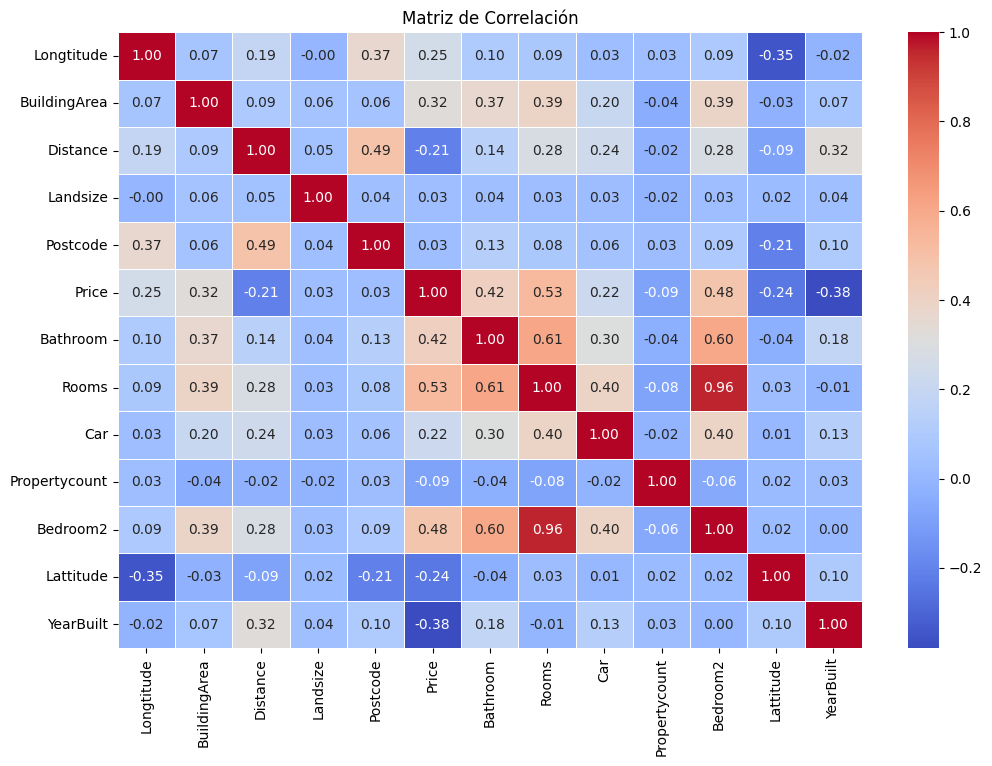

In [11]:
correlation_threshold = 0.3 # Ajuste para seleccionar solo correlaciones significativas
correlation_matrix = melbourne_df[total_numeric_cols].corr()
selected_num_cols = correlation_matrix["Price"].abs().sort_values(ascending=False)
num_cols = selected_num_cols[selected_num_cols > correlation_threshold].index.tolist()
num_cols.remove("Price")
print("Variables numéricas seleccionadas tras la matriz de correlación:", num_cols)
# Visualización de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

In [12]:
# Identificar columnas categóricas
categorical_cols = melbourne_df.select_dtypes(include='category').columns.tolist()
print("Columnas categóricas:", categorical_cols)

Columnas categóricas: ['Type', 'SellerG', 'Regionname', 'CouncilArea', 'Address', 'Method', 'Suburb']


In [13]:
selected_cat_cols = []
for cat in categorical_cols:
    unique_values = melbourne_df[cat].nunique()
    if 1 < unique_values < 50:  # Filtrar variables con valores únicos excesivos
        groups = [melbourne_df[melbourne_df[cat] == value]["Price"] for value in melbourne_df[cat].unique() if len(melbourne_df[melbourne_df[cat] == value]) > 1]
        if len(groups) > 1:
            f_stat, p_value = f_oneway(*groups)
            if p_value < 0.01:
                selected_cat_cols.append(cat)

print("Variables categóricas seleccionadas por ANOVA:", selected_cat_cols)

Variables categóricas seleccionadas por ANOVA: ['Type', 'Regionname', 'CouncilArea', 'Method']


In [14]:
# Eliminar outliers en variables numéricas usando IQR
def remove_outliers_iqr(df, numeric_cols):
    df_filtered = df.copy()
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    return df_filtered

melbourne_df = remove_outliers_iqr(melbourne_df, num_cols)

In [15]:
# Imputación de valores faltantes antes del preprocesamiento
imputer = SimpleImputer(strategy="mean")  # O "median", "most_frequent"
melbourne_df[num_cols] = imputer.fit_transform(melbourne_df[num_cols])

In [16]:
# Preprocesamiento
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])


cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown='ignore'))
])

In [17]:
preprocessor = ColumnTransformer([
    ("numeric", numeric_pipe, num_cols),
    ("categoric", cat_pipe, selected_cat_cols)
])

X_features = melbourne_df[num_cols + selected_cat_cols]
Y_target = melbourne_df["Price"]

x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=None
)

In [18]:
preprocessed_data = preprocessor.fit(x_train)
x_train_preprocessed = preprocessor.transform(x_train)
x_train_preprocessed = pd.DataFrame(x_train_preprocessed.toarray(), columns=preprocessor.get_feature_names_out())

In [19]:
x_train_preprocessed.head()

,numeric__Rooms,numeric__Bedroom2,numeric__Bathroom,numeric__YearBuilt,numeric__BuildingArea,categoric__Type_t,categoric__Type_u,categoric__Regionname_Eastern Victoria,categoric__Regionname_Northern Metropolitan,categoric__Regionname_Northern Victoria,...,categoric__CouncilArea_Stonnington City Council,categoric__CouncilArea_Whitehorse City Council,categoric__CouncilArea_Whittlesea City Council,categoric__CouncilArea_Wyndham City Council,categoric__CouncilArea_Yarra City Council,categoric__CouncilArea_Yarra Ranges Shire Council,categoric__Method_S,categoric__Method_SA,categoric__Method_SP,categoric__Method_VB
0,0.6,0.666667,0.5,0.937500,0.758958,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.2,0.500000,0.0,0.381944,0.374593,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.8,0.833333,1.0,0.243056,0.449511,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.4,0.500000,0.0,0.451389,0.345277,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.6,0.666667,0.5,0.798611,0.495114,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [20]:
x_train.head()

,Rooms,Bedroom2,Bathroom,YearBuilt,BuildingArea,Type,Regionname,CouncilArea,Method
28635,4.0,4.0,2.0,2010.0,233.0,h,Western Metropolitan,Maribyrnong City Council,S
56545,2.0,3.0,1.0,1930.0,115.0,h,Southern Metropolitan,Glen Eira City Council,S
53663,5.0,5.0,3.0,1910.0,138.0,h,Southern Metropolitan,Port Phillip City Council,VB
18323,3.0,3.0,1.0,1940.0,106.0,h,Western Metropolitan,Hobsons Bay City Council,S
31099,4.0,4.0,2.0,1990.0,152.0,t,Northern Metropolitan,Banyule City Council,S
